In [56]:
!pip install neo4j


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [57]:
from neo4j import GraphDatabase

url = "bolt://localhost:7687"
username = "neo4j"
password = "password"

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [58]:
driver

In [ ]:
# Start new container with GDS plugin
!docker run -d \
  -p 7687:7687 -p 7474:7474 \
  --env NEO4J_AUTH=neo4j/password \
  --env NEO4J_PLUGINS='["graph-data-science"]' \
  neo4j:latest

docker: Error response from daemon: Conflict. The container name "/neo4j-test" is already in use by container "36110be33a07b67894b224b27078a87f6b71a398e57a891fa7eac2beba4eff22". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


Let's define a simple encapsulation function to run a cypher query into our neo4j container 

In [60]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.to_df()

In [61]:
run_query("""
SHOW DATABASES;
"""
)

,name,type,aliases,access,address,role,writer,requestedStatus,currentStatus,statusMessage,default,home,constituents
0,neo4j,standard,[],read-write,localhost:7687,primary,True,online,online,,True,True,[]
1,system,system,[],read-write,localhost:7687,primary,True,online,online,,False,False,[]


In [62]:
run_query("""
CREATE CONSTRAINT IF NOT EXISTS FOR (s:Stream) REQUIRE s.id IS UNIQUE;
"""
)

""


In [63]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3JjgKgZ" AS row
MERGE (s:Stream {id: row.id})
SET s.language = row.language
"""
)

""


In [ ]:
# Load the data 
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3S9Uyd8" AS row
CALL{
    WITH row
    MATCH (s:Stream {id:row.source})
    MATCH (t:Stream {id:row.target})
    MERGE (s)-[r:SHARED_AUDIENCE]->(t)
    SET r.weight = toInteger(row.weight)
} IN TRANSACTIONS
""")

Received notification from DBMS server: <GqlStatusObject gql_status='01N00', status_description='warn: feature deprecated. CALL subquery without a variable scope clause is deprecated. Use CALL (row) { ... }', position=<SummaryInputPosition line=3, column=1, offset=60>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 60, 'line': 3, 'column': 1}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nLOAD CSV WITH HEADERS FROM "https://bit.ly/3S9Uyd8" AS row\nCALL{\n    WITH row\n    MATCH (s:Stream {id:row.source})\n    MATCH (t:Stream {id:row.target})\n    MERGE (s)-[r:SHARED_AUDIENCE]->(t)\n    SET r.weight = toInteger(row.weight)\n} IN TRANSACTIONS\n'


""


In [66]:
run_query("""
CALL gds.graph.project("twitch", "Stream", 
  {SHARED_AUDIENCE: {orientation: "UNDIRECTED", properties:["weight"]}})
"""
)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'properties': {}, 'label': 'Stream'}}",{'SHARED_AUDIENCE': {'orientation': 'UNDIRECTE...,twitch,3721,262854,1382


In [67]:
# run query to create node2vec embeddings
run_query("""
CALL gds.beta.node2vec.write('twitch', 
  {embeddingDimension:8, relationshipWeightProperty:'weight',
   inOutFactor:0.5, returnFactor:1, writeProperty:'node2vec'})
"""
)

Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. gds.beta.node2vec.write is deprecated. It is replaced by gds.node2vec.write.', position=<SummaryInputPosition line=2, column=1, offset=1>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 1, 'line': 2, 'column': 1}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\nCALL gds.beta.node2vec.write('twitch', \n  {embeddingDimension:8, relationshipWeightProperty:'weight',\n   inOutFactor:0.5, returnFactor:1, writeProperty:'node2vec'})\n"


,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration,lossPerIteration
0,3721,3721,11,3403,78,"{'negativeSamplingExponent': 0.75, 'negativeSa...",[22264917.200490557]


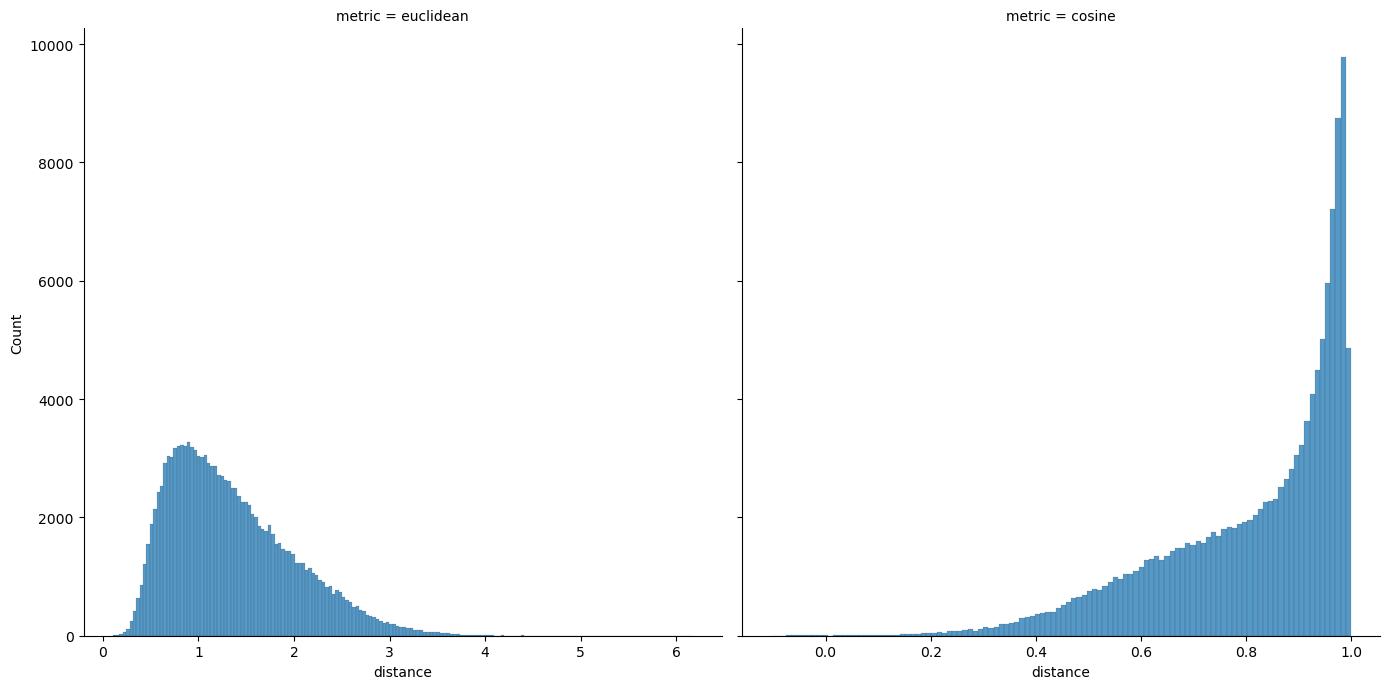

In [68]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16, 9]
import seaborn as sns

df = run_query("""
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
RETURN gds.similarity.euclideanDistance(
   c1.node2vec, c2.node2vec) AS distance, 'euclidean' as metric
UNION
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
RETURN gds.similarity.cosine(
   c1.node2vec, c2.node2vec) AS distance, 'cosine' as metric
"""
)

sns.displot(
    data=df,
    x="distance",
    col="metric",
    common_bins=False,
    facet_kws=dict(sharex=False),
    height=7,
)

<Axes: xlabel='cosineSimilarity', ylabel='avgDegree'>

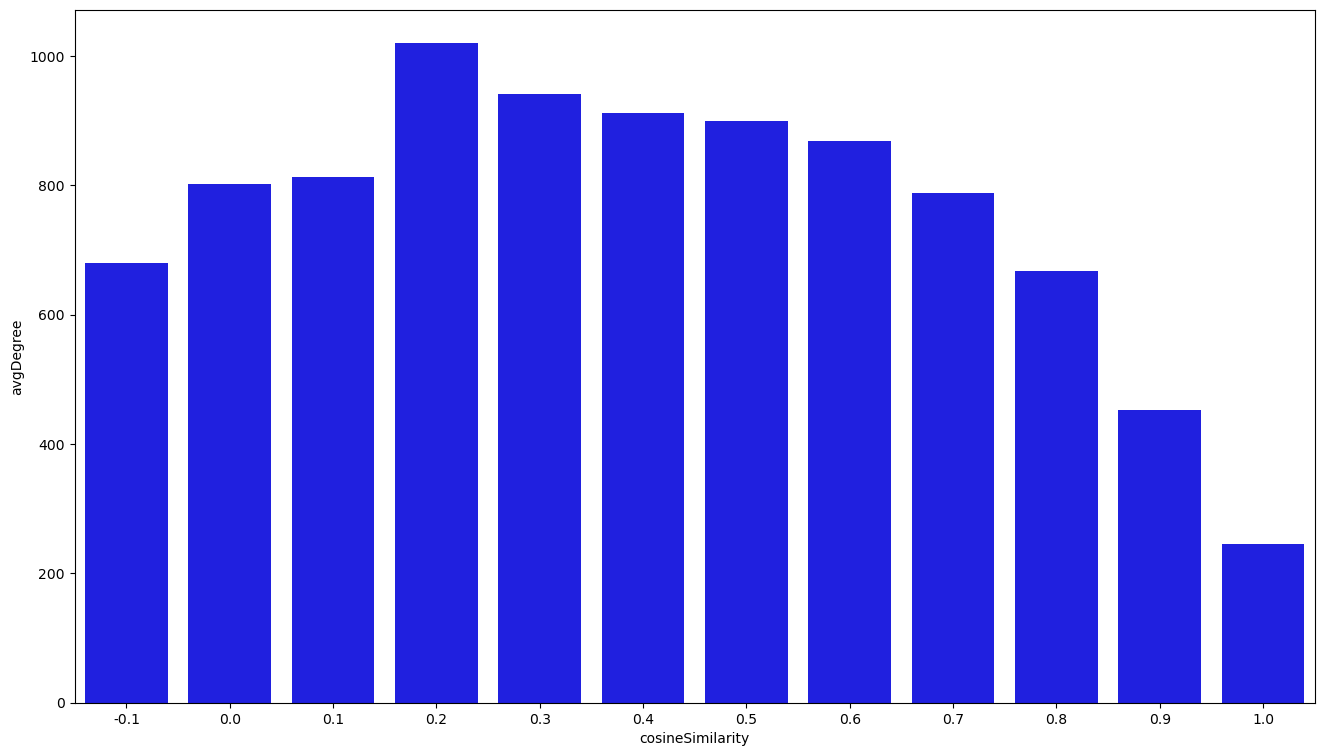

In [69]:
df = run_query("""
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
WITH c1, c2, gds.similarity.cosine(c1.node2vec, c2.node2vec) AS cosineSimilarity,
     count{ (c1)-[:SHARED_AUDIENCE]-() } AS degree1,
     count{ (c2)-[:SHARED_AUDIENCE]-() } AS degree2
RETURN round(cosineSimilarity,1) AS cosineSimilarity, avg(degree1 + degree2) AS avgDegree
ORDER BY cosineSimilarity
"""
)

sns.barplot(data=df, x="cosineSimilarity", y="avgDegree", color="blue")

<Axes: xlabel='cosineSimilarity', ylabel='avgWeight'>

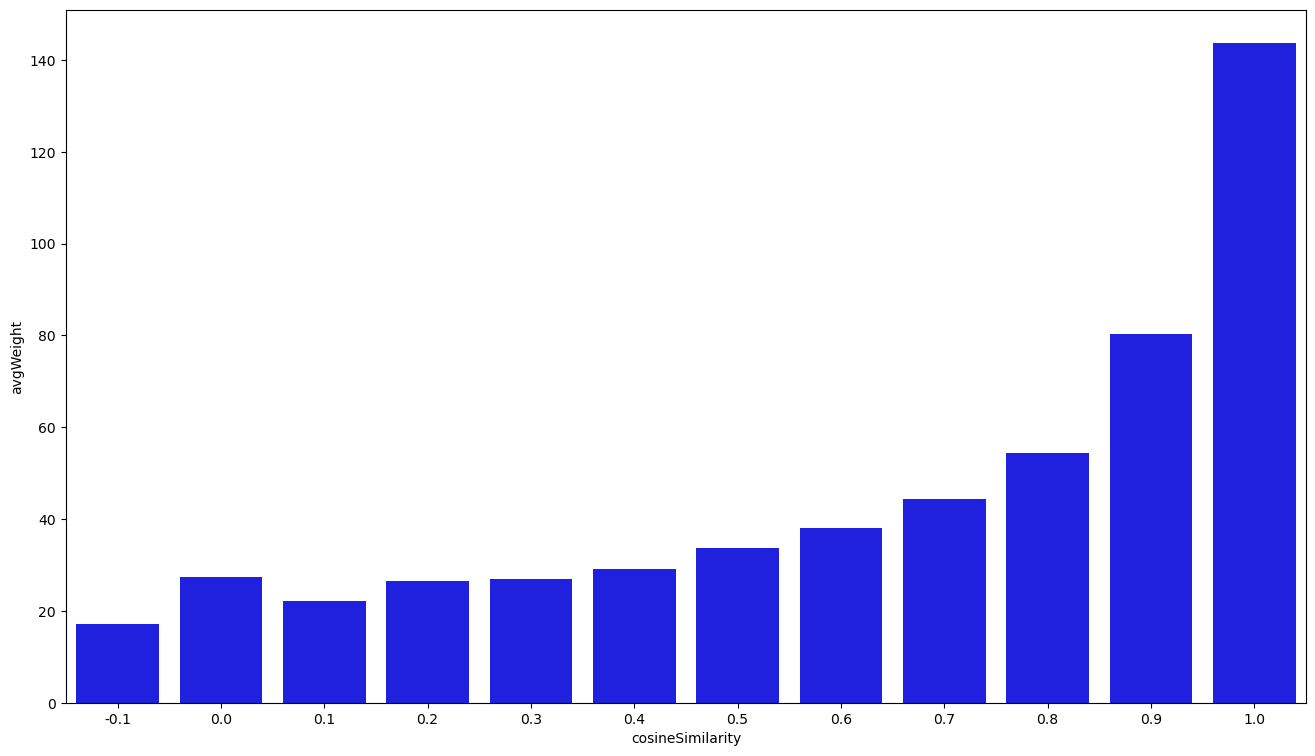

In [70]:
df = run_query("""
MATCH (c1:Stream)-[r:SHARED_AUDIENCE]->(c2:Stream)
WITH c1, c2, gds.similarity.cosine(c1.node2vec, c2.node2vec) AS cosineSimilarity,
     r.weight AS weight
RETURN round(cosineSimilarity,1) AS cosineSimilarity, avg(weight) AS avgWeight
ORDER BY cosineSimilarity
"""
)

sns.barplot(data=df, x="cosineSimilarity", y="avgWeight", color="blue")

In [71]:
import pandas as pd
data = run_query("""
MATCH (s:Stream)
RETURN s.id AS streamId, s.language AS language, s.node2vec AS embedding
"""
)
data["output"] = pd.factorize(data["language"])[0]

In [72]:
data.head()

,streamId,language,embedding,output
0,129004176,en,"[-1.4471642971038818, 0.008464712649583817, 0....",0
1,26490481,en,"[-1.0847314596176147, -0.5945352911949158, -0....",0
2,213749122,en,"[-1.159714698791504, 0.6598212718963623, 0.888...",0
3,30104304,en,"[-1.2779196500778198, -0.12590914964675903, 0....",0
4,160504245,en,"[-1.0712976455688477, -0.08606241643428802, -0...",0


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data["embedding"].to_list()
y = data["output"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [74]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       384
           1       0.94      0.87      0.90        54
           2       0.98      0.93      0.96        59
           3       0.80      0.82      0.81        39
           4       0.87      0.92      0.90        52
           5       0.89      0.88      0.89        58
           6       1.00      0.95      0.97        20
           7       0.93      1.00      0.96        25
           8       0.94      0.94      0.94        35
           9       0.95      1.00      0.97        19

    accuracy                           0.92       745
   macro avg       0.92      0.92      0.92       745
weighted avg       0.92      0.92      0.92       745



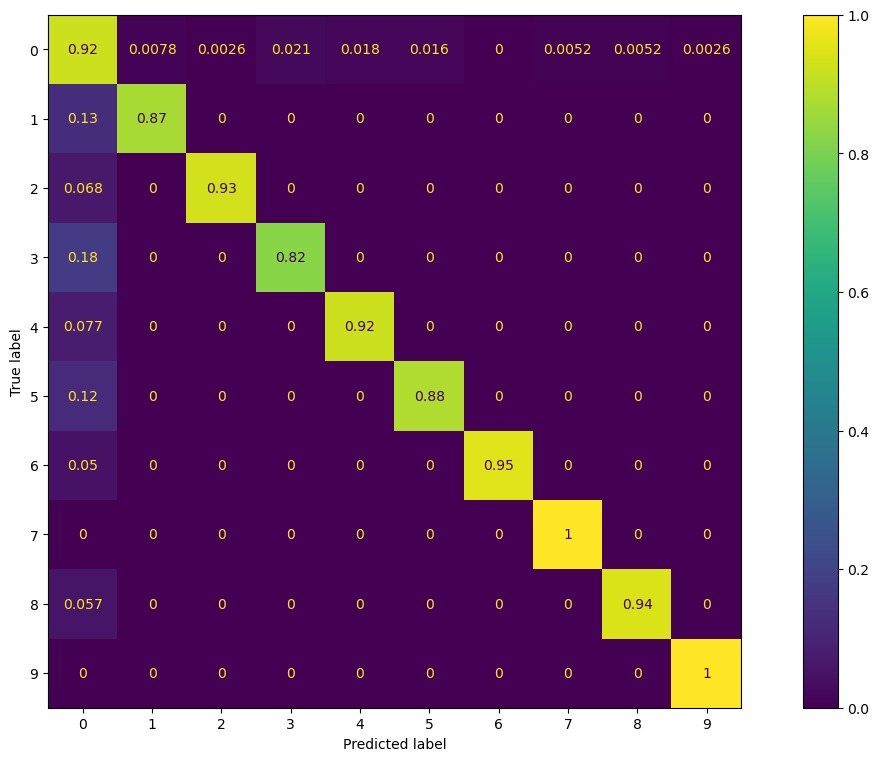

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")